In [1]:
from persist.persist import PersistentDAG

from persist.persist import PersistentDAG
from functools import wraps

# global variable to simulate the fact to have serialize data somewhere
global IS_COMPUTED
IS_COMPUTED = dict()

from time import sleep
def load_data(*args, **kwargs):
    sleep(2)
    print 'load data ...'
    if args:
        print args
        return 'data_{}'.format(args)
    if kwargs:
        print kwargs
        return 'data_{}'.format(kwargs)
    return 'data'


def clean_data(data, *args, **kwargs):
    assert isinstance(data, str)
    print 'clean data ...'
    if args:
        print args
        data = data + '_' + '_'.join(map(lambda x: '{}'.format(x), args))
    if kwargs:
        print kwargs
        data = data + '_' + \
            '_'.join(map(lambda kv: '{}_{}'.format(
                kv[0], kv[1]), kwargs.items()))
    return 'cleaned_{}'.format(data)


def analyze_data(cleaned_data, option=1, **other_options):
    assert isinstance(cleaned_data, str)
    print 'analyze data ...'
    return 'analyzed_{}'.format(cleaned_data)



class Serializer(object):

    def __init__(self):
        pass

    def load(self, key):
        print "load data for key {} ...".format(key)
        return IS_COMPUTED[key]

    def dump(self, key, value):
        print "save data with key {} ...".format(key)
        IS_COMPUTED[key] = value

    def is_computed(self, key):
        global IS_COMPUTED
        return IS_COMPUTED.get(key) is not None

    def delayed_load(self, key):
        def load():
            return self.load(key)
        return load

    def dump_result(self, func, key):
        @wraps(func)
        def wrapped_func(*args, **kwargs):
            result = func(*args, **kwargs)
            self.dump(key, result)
            return result
        return wrapped_func

In [2]:
g = PersistentDAG()
serializer = Serializer()
g.add_task(load_data, option=10,
           dask_key_name='key_data1', 
           # dask_serializer=serializer 
          )
g.add_task(load_data, option=20,
           dask_key_name='key_data2', 
           # dask_serializer=serializer
          )

kwargs = dict(data='key_data1', other='key_data2')
g.add_task(clean_data,
           dask_key_name='cleaned_data', 
           dask_serializer=serializer,
           **kwargs)
g.add_task(analyze_data, 'cleaned_data')

Delayed('analyze_data-e62242de7382977d642fc55ed1c97a89')

In [3]:
#from distributed import Client
#Client()

In [4]:
data = g.persist()

load data ...
{'option': 10}
load data ...
{'option': 20}
clean data ...
{'other': "data_{'option': 20}"}
save data with key cleaned_data ...
analyze data ...


In [5]:
data

In [6]:
g.run()

load data ...
{'option': 10}
load data ...
{'option': 20}
load data ...
{'option': 10}
clean data ...
{'other': "data_{'option': 20}"}
save data with key cleaned_data ...
load data ...
{'option': 20}
load data ...load data ...
{'option': 10}

{'option': 20}
clean data ...
{'other': "data_{'option': 20}"}
save data with key cleaned_data ...
analyze data ...


{'analyze_data-e62242de7382977d642fc55ed1c97a89': Delayed('analyze_data-e62242de7382977d642fc55ed1c97a89'),
 'cleaned_data': Delayed('cleaned_data'),
 'key_data1': Delayed('key_data1'),
 'key_data2': Delayed('key_data2')}

In [7]:
data.compute()

["analyzed_cleaned_data_{'option': 10}_other_data_{'option': 20}"]

In [8]:
IS_COMPUTED

{'cleaned_data': "cleaned_data_{'option': 10}_other_data_{'option': 20}"}

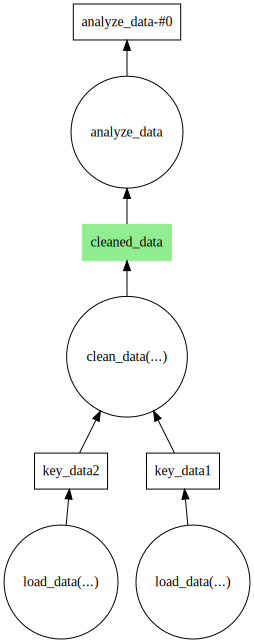

In [9]:
# g.visualize(format='svg', filename='persist')
g.visualize(format='svg')

In [10]:
data = g.submit(analyze_data, 'cleaned_data')
data.compute()

load data ...
{'option': 10}
load data ...
{'option': 20}
clean data ...
{'other': "data_{'option': 20}"}
save data with key cleaned_data ...
analyze data ...


"analyzed_cleaned_data_{'option': 10}_other_data_{'option': 20}"

In [11]:
import dask
with dask.set_options(get=dask.async.get_sync):
    g.run()

load data ...
{'option': 10}
load data ...
{'option': 10}
load data ...
{'option': 20}
clean data ...
{'other': "data_{'option': 20}"}
save data with key cleaned_data ...
load data ...
{'option': 20}
load data ...
{'option': 10}
load data ...
{'option': 20}
clean data ...
{'other': "data_{'option': 20}"}
save data with key cleaned_data ...
analyze data ...


In [12]:
IS_COMPUTED

{'cleaned_data': "cleaned_data_{'option': 10}_other_data_{'option': 20}"}

In [13]:
%pylab inline

Populating the interactive namespace from numpy and matplotlib


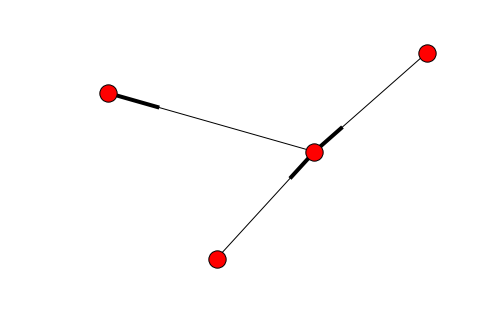

In [14]:
graph = g.to_digraph()
import networkx as nx
nx.draw(graph)

In [15]:
from distributed import Client
client = Client()
global IS_COMPUTED
IS_COMPUTED = {}

distributed.comm.tcp - WARNING - Could not set timeout on TCP stream: [Errno 42] Protocol not available
distributed.comm.tcp - WARNING - Could not set timeout on TCP stream: [Errno 42] Protocol not available
distributed.comm.tcp - WARNING - Could not set timeout on TCP stream: [Errno 42] Protocol not available
distributed.comm.tcp - WARNING - Could not set timeout on TCP stream: [Errno 42] Protocol not available
distributed.comm.tcp - WARNING - Could not set timeout on TCP stream: [Errno 42] Protocol not available
distributed.comm.tcp - WARNING - Could not set timeout on TCP stream: [Errno 42] Protocol not available
distributed.comm.tcp - WARNING - Could not set timeout on TCP stream: [Errno 42] Protocol not available
distributed.comm.tcp - WARNING - Could not set timeout on TCP stream: [Errno 42] Protocol not available
distributed.comm.tcp - WARNING - Could not set timeout on TCP stream: [Errno 42] Protocol not available
distributed.comm.tcp - WARNING - Could not set timeout on TCP st

In [16]:
g.persist()

In [17]:
g.compute()

distributed.comm.tcp - WARNING - Could not set timeout on TCP stream: [Errno 42] Protocol not available


["analyzed_cleaned_data_{'option': 10}_other_data_{'option': 20}"]

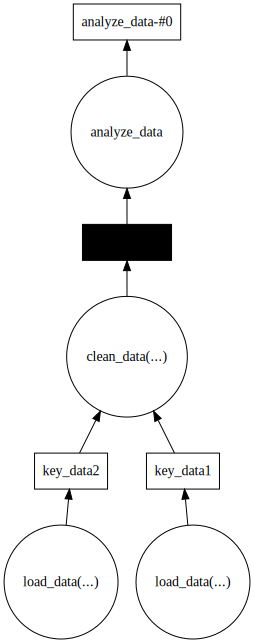

In [18]:
g.visualize(format='svg')

In [19]:
# TODO: we have to use a real serializer in order to make things work with futures.